# Coloring Graphs by RSN

Goal: color each node with multiple (activated) networks.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import dyneusr as ds
import kmapper as km
import networkx as nx

In [3]:
import numpy as np
import pandas as pd
import scipy.stats

from sklearn.datasets.base import Bunch
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import MDS, TSNE

from umap.umap_ import UMAP
from hdbscan import HDBSCAN

In [4]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

In [5]:
from collections import Counter, OrderedDict
from functools import partial
from itertools import product

## Load sessions

In [118]:
from load_data import load_scrubbed

session, = load_scrubbed(n_sessions=1, merge=False)

INFO:load_data:load_scrubbed(**{'n_sessions': 1, 'merge': False})
INFO:load_data:Loading data...
INFO:root:  [+] session: 1, path: data/base/combined_data_scrubbed/sub014.txt


## Resting-State Network parcellation labels

In [123]:
def load_atlas():
    df_parcel = pd.read_table(
        'data/base/parcellation/parcel_data.txt', 
        header=None
        )

    # relabel columns
    df_parcel = df_parcel.iloc[:, [0,2,3,4,5,7]]
    df_parcel.columns = ['target','x','y','z','label','network']

    # region_coords: (x, y, z)
    df_coords = df_parcel[['x', 'y', 'z']]

    # labels: string list of region labels
    df_labels = df_parcel[['label']]

    # networks: names of the networks
    df_networks = df_parcel[['network']]
    
    # Bunch
    atlas = Bunch(
        labels=df_labels,
        region_coords=df_coords,
        networks=df_networks,
        )
    return atlas

In [138]:
def get_RSN_act(x, atlas, threshold=0.5, zscore=True):
    """ Compute mean activity for RSN at each TR.
    
    Inputs
    ------
        :x = np.ndarray (TR, ROI)
        
        :atlas = pd.DataFrame.networks = (ROI, RSN)
        
    """
    x_ = x.copy() 
    
    # z-score (?)
    if zscore is True:
        x_ = scipy.stats.zscore(x_, axis=0)

    # get average RSN activity for each network
    # TODO: this could be its own function
    rsn_rois = atlas.networks.groupby('network').indices.items()
    rsn_act = {rsn: x_[:, rois].mean(axis=1) for (rsn, rois) in rsn_rois}

    # save as DataFrame
    df_rsn_act = pd.DataFrame(rsn_act)
    
    # threshold (?)
    if threshold:
        df_rsn_act = df_rsn_act.ge(0.5).astype(int)
    
    return df_rsn_act

In [139]:
df_rsn_bin = get_RSN_act(session.X, session.atlas)
df_rsn_act = get_RSN_act(session.X, session.atlas, threshold=None)

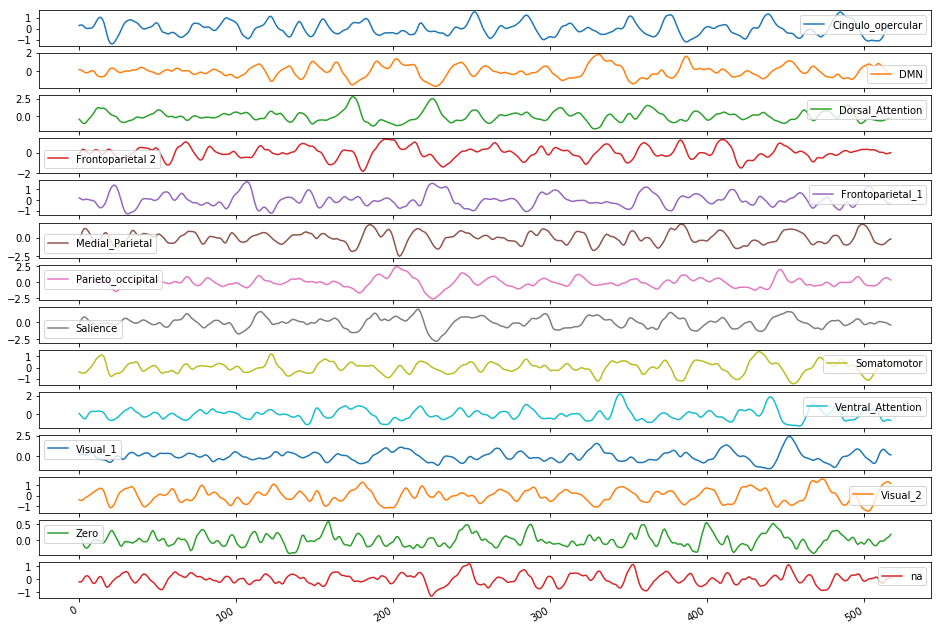

In [127]:
_ = df_rsn_act.plot(subplots=True,figsize=(16,12))

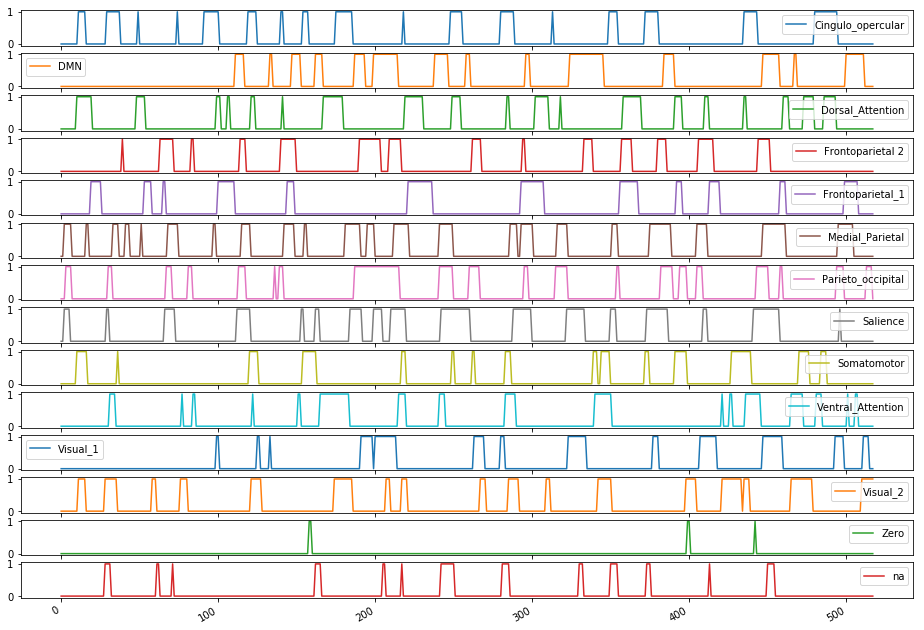

In [131]:
_ = df_rsn_bin.plot(subplots=True,figsize=(16,12))

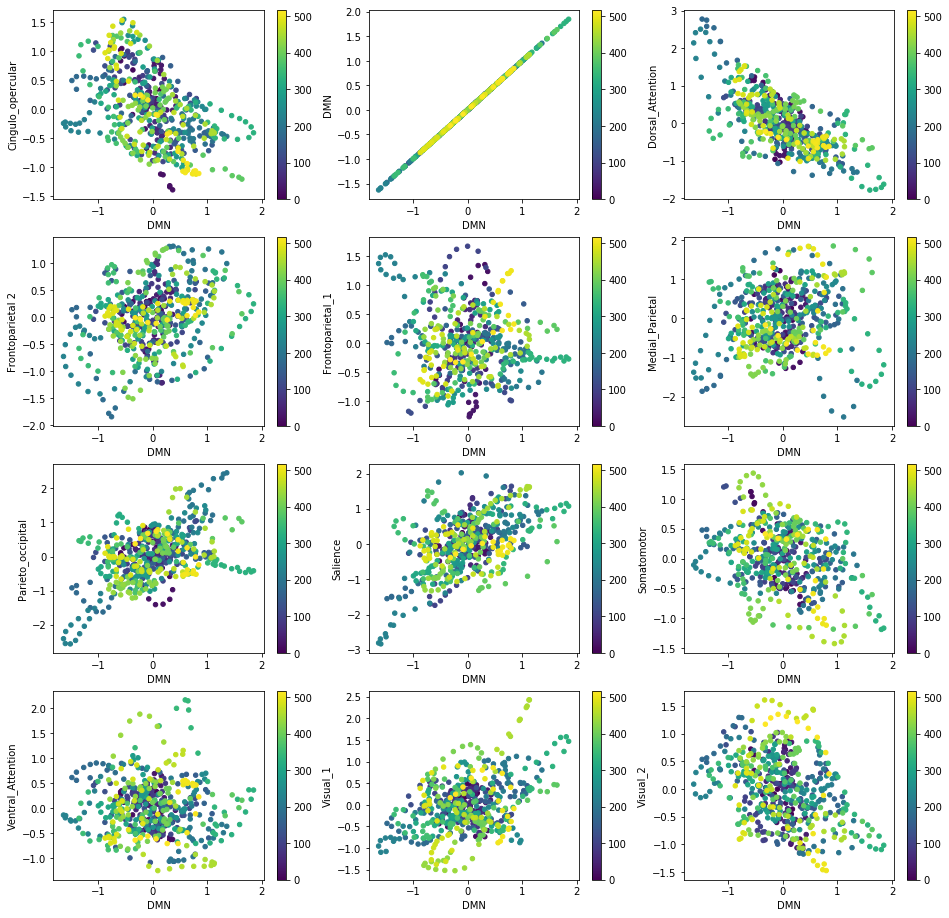

In [163]:
fig,axes = plt.subplots(4,3, figsize=(16,16))
axes = np.ravel(axes)

for i,c in enumerate(df_rsn_act.columns[:-2]):
    _ = df_rsn_act.plot.scatter(
        x='DMN', y=c, c=df_rsn_act.index, 
        cmap='viridis', 
        ax=axes[i],
        )

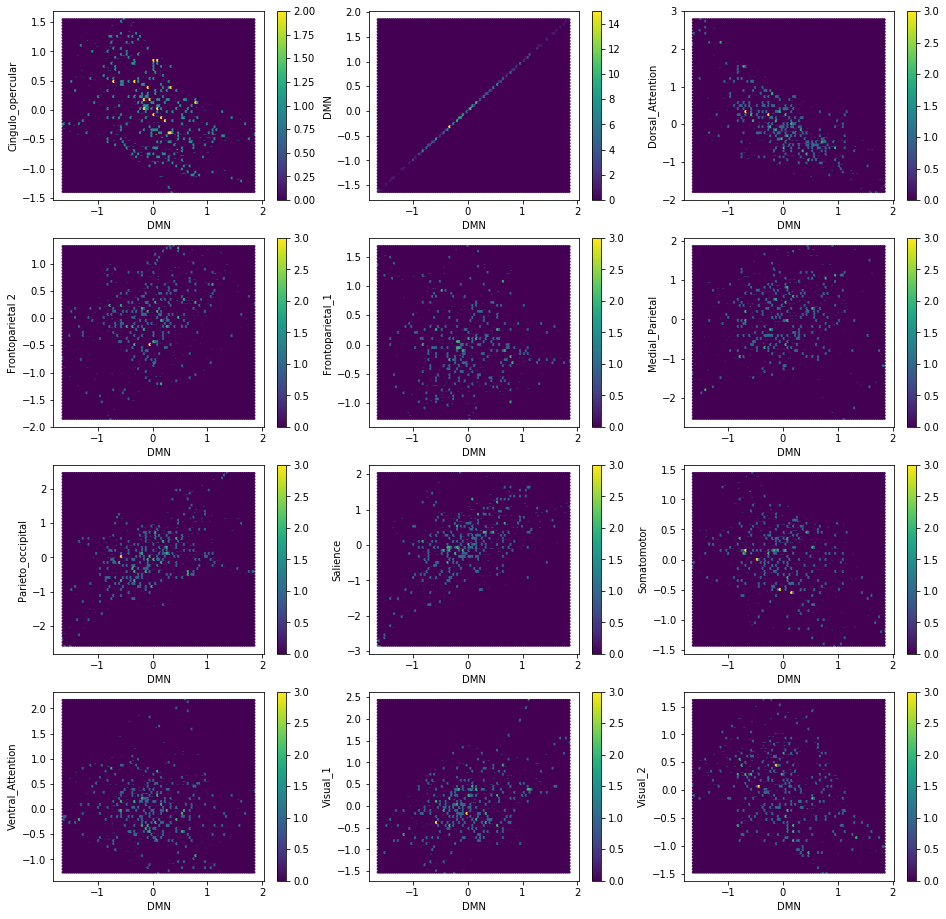

In [172]:
fig,axes = plt.subplots(4,3, figsize=(16,16))
axes = np.ravel(axes)

for i,c in enumerate(df_rsn_act.columns[:-2]):
    _ = df_rsn_act.plot.hexbin(
        x='DMN', y=c,
        #c=df_rsn_bin.index, 
        cmap='viridis', 
        ax=axes[i],
        )

In [ ]:
df_rsn_act.

### Wrap into `RSNColoring`

In [ ]:
class NodePieColoring:
    pass

class RSNColoring:
    pass

class RSNMultiColoring:
    pass


def get_RSN_coloring():
    pass

def get_RSN_multi_coloring():
    pass

## Mapper

In [176]:
def get_PC(df, columns=None):
    """ Find PC with max weight assigned to column.
    """
    # extract X
    X = df.values
    
    # fit transform PCA
    from sklearn.decomposition import PCA
    pca = PCA()
    U = pca.fit_transform(X)
    V = pca.components_
    
    # create new DataFrame of components (V)
    df_V = pd.DataFrame(V, columns=df.columns)
    df_V.index = df_V.index.map('PC_{}'.format)
   
    # create new DataFrame of embedding (U)
    df_U = pd.DataFrame(U, index=df.index, columns=df_V.index)
    
    # set column to 0,1 or idxmax   
    if columns is None:
        columns = pd.Series(df_U.columns[:2])
    else:
        columns = [_ for _ in np.ravel(columns)]
        columns = df_V[columns].idxmax()   

    # return PC for col
    df_PC = df_U[columns]
    df_PC.columns = dict(columns).items()
    return df_PC


In [175]:
from load_data import load_scrubbed

combined = load_scrubbed(n_sessions=10, merge=True)

INFO:load_data:load_scrubbed(**{'n_sessions': 10, 'merge': True})
INFO:load_data:Loading data...
INFO:root:  [+] session: 1, path: data/base/combined_data_scrubbed/sub014.txt
INFO:root:  [+] session: 2, path: data/base/combined_data_scrubbed/sub015.txt
INFO:root:  [+] session: 3, path: data/base/combined_data_scrubbed/sub016.txt
INFO:root:  [+] session: 4, path: data/base/combined_data_scrubbed/sub017.txt
INFO:root:  [+] session: 5, path: data/base/combined_data_scrubbed/sub018.txt
INFO:root:  [+] session: 6, path: data/base/combined_data_scrubbed/sub019.txt
INFO:root:  [+] session: 7, path: data/base/combined_data_scrubbed/sub020.txt
INFO:root:  [+] session: 8, path: data/base/combined_data_scrubbed/sub021.txt
INFO:root:  [+] session: 9, path: data/base/combined_data_scrubbed/sub022.txt
INFO:root:  [+] session: 10, path: data/base/combined_data_scrubbed/sub023.txt


In [248]:
sessions = load_scrubbed(n_sessions=10, merge=False)

INFO:load_data:load_scrubbed(**{'n_sessions': 10, 'merge': False})
INFO:load_data:Loading data...
INFO:root:  [+] session: 1, path: data/base/combined_data_scrubbed/sub014.txt
INFO:root:  [+] session: 2, path: data/base/combined_data_scrubbed/sub015.txt
INFO:root:  [+] session: 3, path: data/base/combined_data_scrubbed/sub016.txt
INFO:root:  [+] session: 4, path: data/base/combined_data_scrubbed/sub017.txt
INFO:root:  [+] session: 5, path: data/base/combined_data_scrubbed/sub018.txt
INFO:root:  [+] session: 6, path: data/base/combined_data_scrubbed/sub019.txt
INFO:root:  [+] session: 7, path: data/base/combined_data_scrubbed/sub020.txt
INFO:root:  [+] session: 8, path: data/base/combined_data_scrubbed/sub021.txt
INFO:root:  [+] session: 9, path: data/base/combined_data_scrubbed/sub022.txt
INFO:root:  [+] session: 10, path: data/base/combined_data_scrubbed/sub023.txt


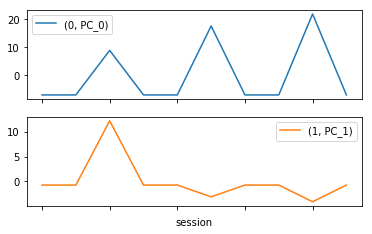

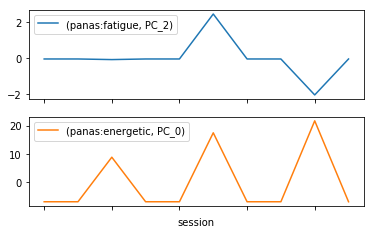

In [249]:
# panas cols
panas_cols = [_ for _ in combined.meta.columns if _.startswith('panas:')]

# clean meta
df_panas = combined.meta[panas_cols]

# group by session
df_panas = df_panas.groupby('session').mean()

# get first PC
df_pc = get_PC(df_panas)
_ = df_pc.plot(subplots=True)

# get PC (max) for panas:fatigue, panas:energetic
df_pc_max = get_PC(df_panas, columns=['panas:fatigue', 'panas:energetic'])
_ = df_pc_max.plot(subplots=True)


# combine
combined.color_functions = df_pc.join(df_pc_max, how='left')

# normalize
combined.color_norms = combined.color_functions.apply([np.min, np.max]).T

In [258]:
for i, session in enumerate(sessions):
    print(i, session.meta.session_id.unique())
    
    # get components from df_pc, df_pc_max
    session_index = session.meta.set_index('session').index
    color_functions = combined.color_functions.loc[session.meta.session, :]

    # set color functions
    sessions[i].color_functions = color_functions.reset_index(drop=True)

    # rsn
    rsn_bin = get_RSN_act(session.X, session.atlas)
    rsn_act = get_RSN_act(session.X, session.atlas, threshold=None)
    sessions[i].rsn_bin = rsn_bin.copy()
    sessions[i].rsn_act = rsn_act.copy()

    
    sessions[i].color_functions_rsn = rsn_act.copy()
    sessions[i].lens = rsn_act.loc[:, ['DAM', 'Dorsal_Attention']].values.copy()

0 [14]
1 [15]
2 [16]
3 [17]
4 [18]
5 [19]
6 [20]
7 [21]
8 [22]
9 [23]


/Users/calebgeniesse/src/miniconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1472: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


In [259]:
def run_mapper(X=None, y=None, X_inverse=True, lens=None, verbose=0, **params):

    # init MAPPER params
    projection = params.get('projection', TSNE(perplexity=50, init='random', random_state=0))
    clusterer = params.get('clusterer', HDBSCAN(allow_single_cluster=True))
    cover = params.get('cover', km.Cover(10, 0.67))
    X_inverse = X if X_inverse is True else X_inverse
    
    # fit
    if lens is None:
        mapper = km.KeplerMapper(verbose=verbose-1)
        lens = mapper.fit_transform(X, projection=projection)
       
    # map
    mapper = km.KeplerMapper(verbose=verbose)
    graph = mapper.map(lens, X_inverse, clusterer=clusterer, coverer=cover)
  
    # dG
    dG = ds.DyNeuGraph()
    dG.fit(graph, y=y)
    
    # save results
    results = Bunch(
        X=X.copy(), X_inverse=X, 
        lens=lens.copy(), graph=graph, 
        params=params, cover=cover,
        dG=dG,
    )
    return results
    
    

In [260]:
for i, session in enumerate(sessions):
    
    print("[(i={}, session={})] Generating graph...".format(
        i, session.meta.session_id.unique()[0]), 
        end="  ")
    color_functions = session.color_functions.copy()
    lens = session.rsn_act.values[:, :2].copy()
    #lens = PCA(n_components=2).fit_transform(lens)
    
    # run mapper
    mapped = run_mapper(
        X=session.X, y=color_functions, X_inverse=True,
        lens=lens,
        #projection=PCA(n_components=2),
        clusterer=HDBSCAN(allow_single_cluster=True), 
        cover=km.Cover(10, 0.67),
        verbose=0,
        ) 
    
    # save
    sessions[i].mapped = mapped
    
    # display some results
    print("nodes={}  edges={}".format(
        mapped.dG.G_.number_of_nodes(),
        mapped.dG.G_.number_of_edges(),
        ))

[(i=0, session=14)] Generating graph...  nodes=57  edges=96
[(i=1, session=15)] Generating graph...  nodes=61  edges=114
[(i=2, session=16)] Generating graph...  nodes=54  edges=103
[(i=3, session=17)] Generating graph...  nodes=67  edges=124
[(i=4, session=18)] Generating graph...  nodes=54  edges=126
[(i=5, session=19)] Generating graph...  nodes=42  edges=86
[(i=6, session=20)] Generating graph...  nodes=54  edges=83
[(i=7, session=21)] Generating graph...  nodes=53  edges=99
[(i=8, session=22)] Generating graph...  nodes=51  edges=97
[(i=9, session=23)] Generating graph...  nodes=57  edges=93


## Color (networkx)

In [261]:
def draw_G(G, y=None, pos=None, ax=None, **kwargs):
    
    # size by number of members
    node_size = kwargs.get('node_size')
    if node_size is None:
        node_size = [1 * len(G.nodes[n]['members'])**1.5 for n in G]
        kwargs.update(node_size=node_size)

    
    # color nodes by mode
    node_color = kwargs.get('node_color')
    if node_color is None and y is not None:
        node_color = [Counter(y[_]).most_common()[0][0] for n,_ in G.nodes('members')]
        kwargs.update(node_color=node_color)
    
    # color nodes by mode
    layout = kwargs.get('layout')
    if pos is None and layout is not None:
        pos = layout(G)
    
    # plot
    _ = nx.draw_networkx(
        G, pos=pos,
        with_labels=False, 
        ax=ax,
        **kwargs
        )
    
    # remove spines
    for spine in ax.spines:
        ax.spines[spine].set_visible(False)
        ax.set_xticks([])
        ax.set_yticks([])

    return ax
    

### Draw graph for each session, color by RSNs

[14]


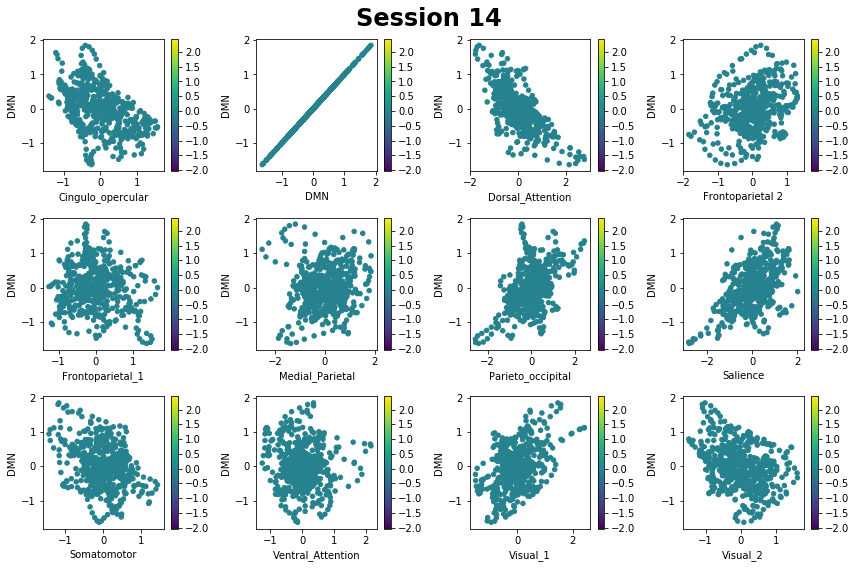

[15]


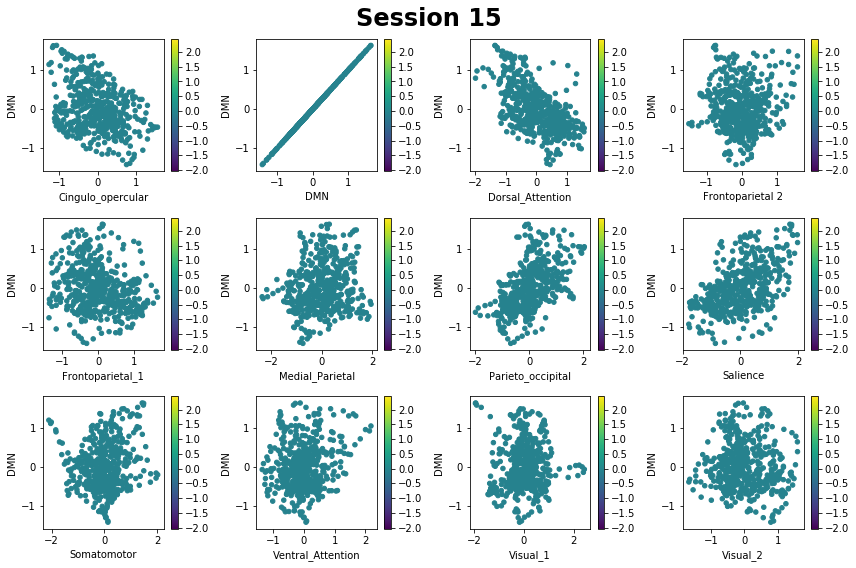

[16]


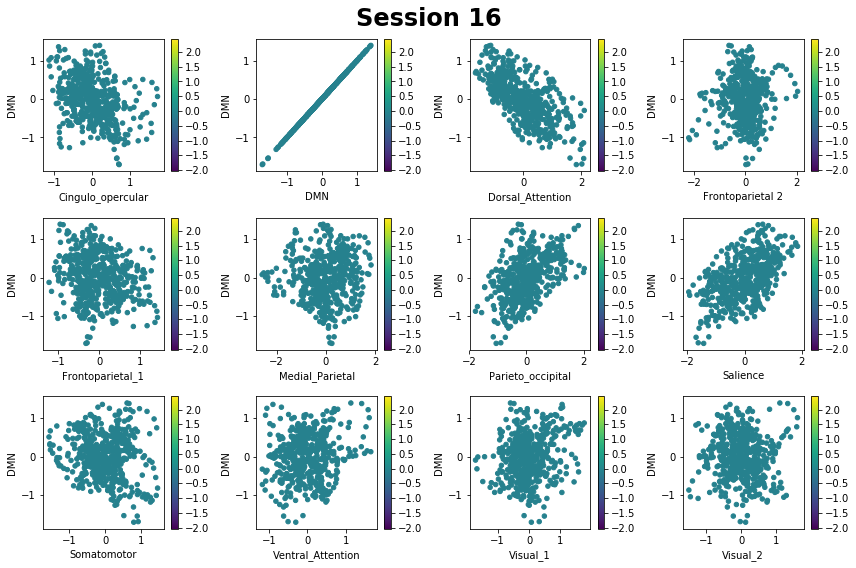

[17]


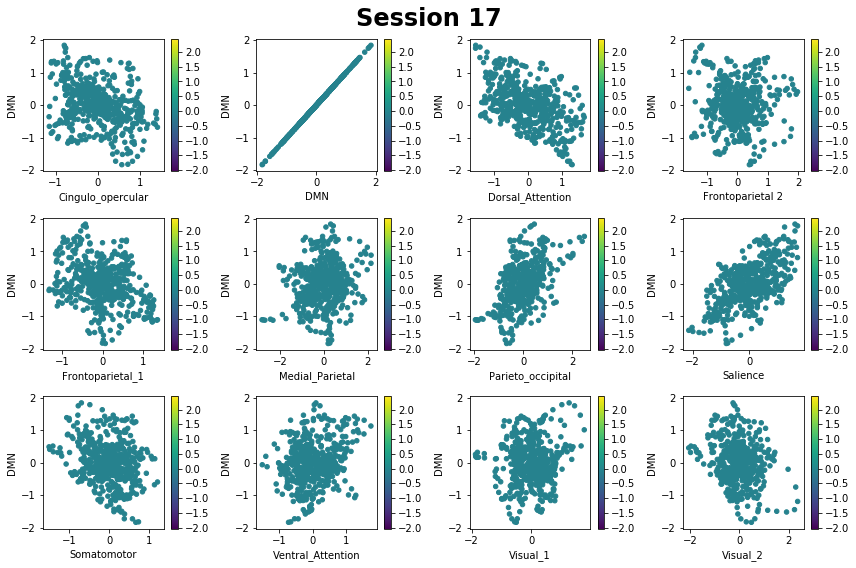

[18]


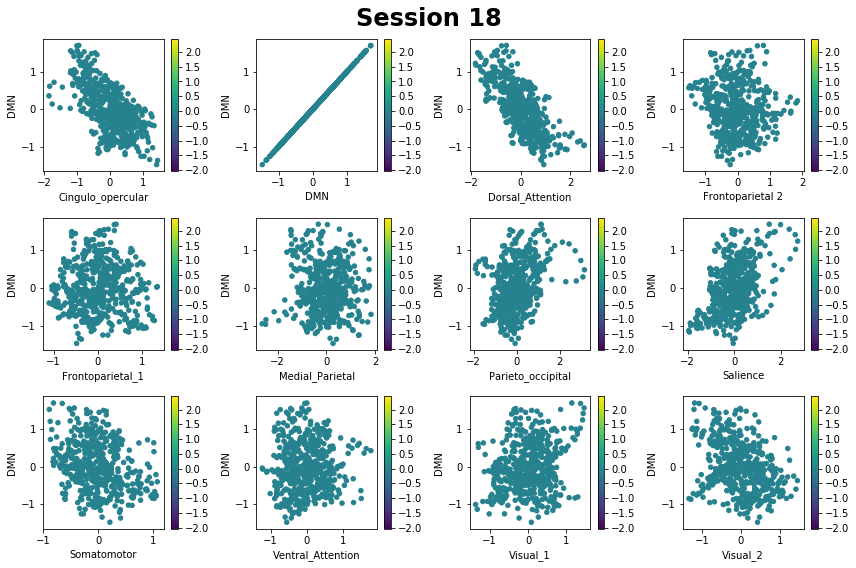

[19]


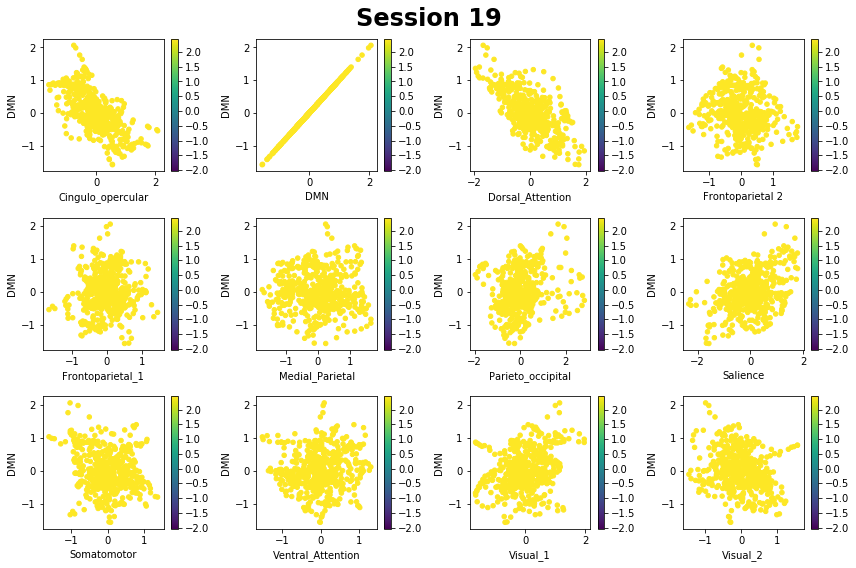

[20]


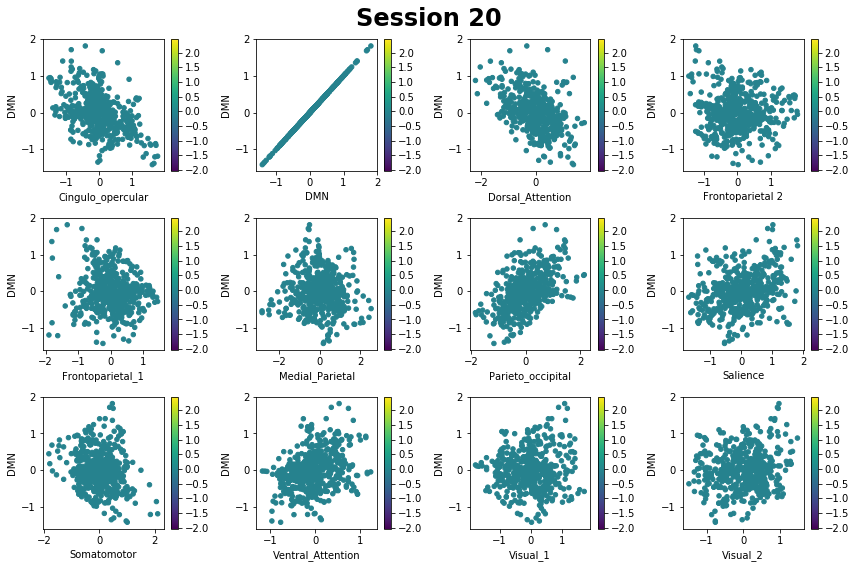

[21]


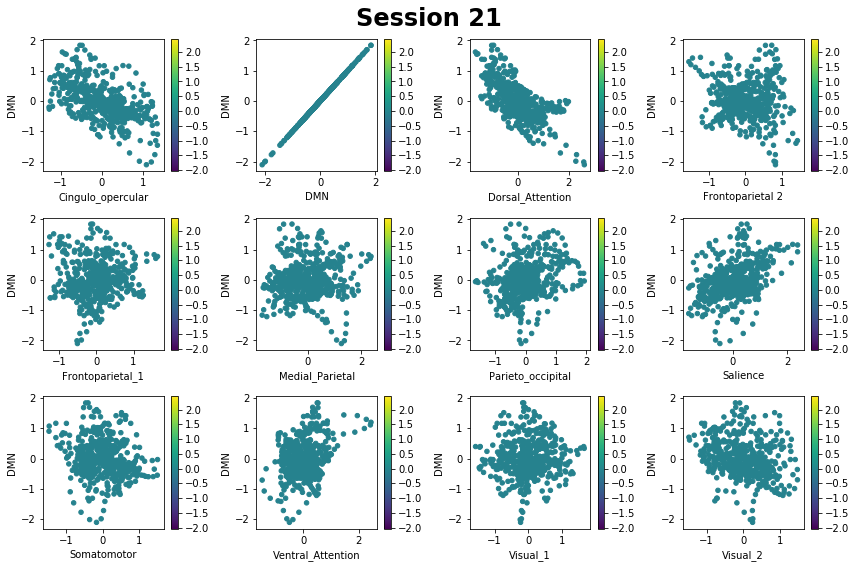

[22]


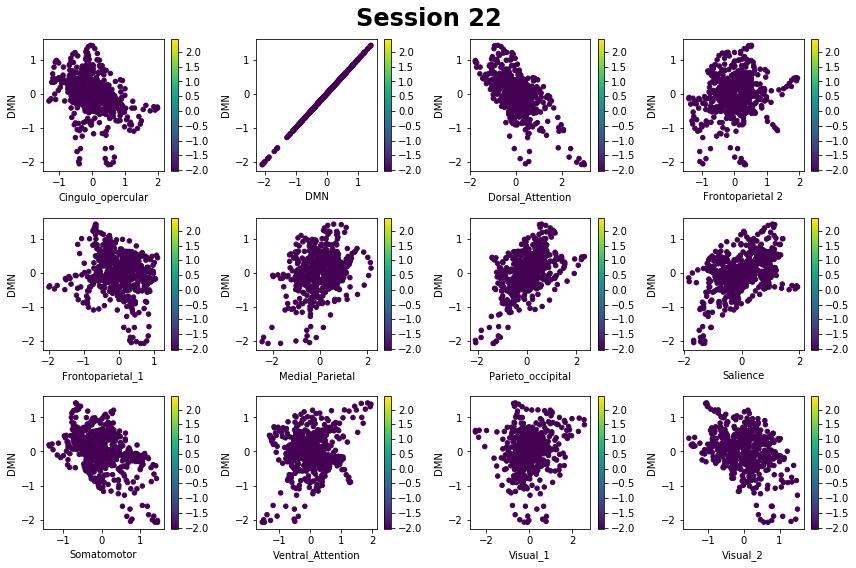

[23]


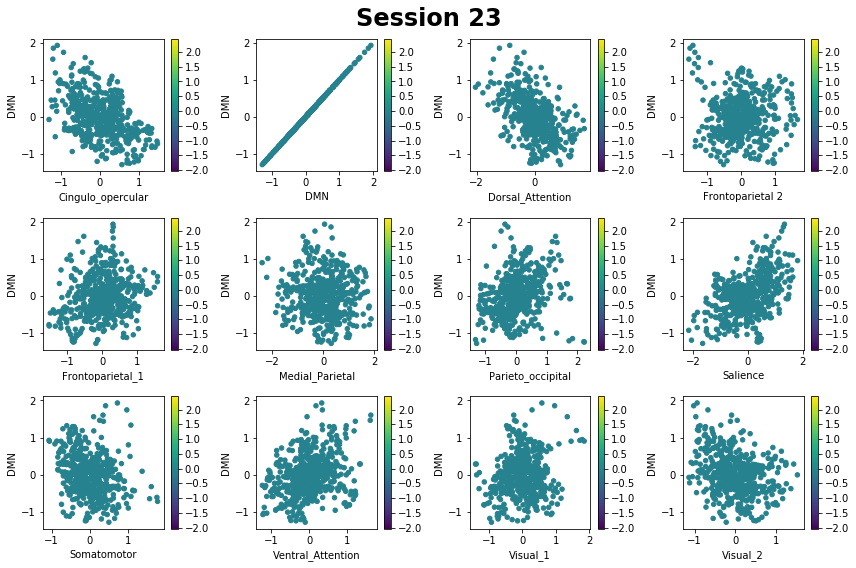

In [266]:
# loop over sessions
for i, session in enumerate(sessions):
    print(session.meta.session_id.unique())

    G = session.mapped.dG.G_.copy()
    color_functions = session.color_functions_rsn.copy()
    rsn_act = session.rsn_act.copy()
    rsn_bin = session.rsn_bin.copy()
    color_labels = list(color_functions.columns)

    # color each session by all color functions
    fig, axes = plt.subplots(3, 4, figsize=(12, 8))
    axes = np.ravel(axes)
    for c_i,c in enumerate(rsn_act.columns[:-2]):
        _ = rsn_act.assign(_index=rsn_act.index).plot.scatter(
            y='DMN', x=c, 
            c=session.color_functions.iloc[:, 2].values,#rsn_act.DMN,#'DMN',
            vmin=combined.color_norms.iloc[2].amin,
            vmax=combined.color_norms.iloc[2].amax,
            cmap='viridis', 
            ax=axes[c_i],
            )
        #if c_i == 0:
        #    ax.set_ylabel(str(session.meta.session_id.values[0]), 
        #        fontsize=16, fontweight='bold'
        #        )
    
    plt.suptitle(
        'Session {}'.format(session.meta.session_id[0]),
        fontsize=24, fontweight='bold'
        )
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()
    


[14]


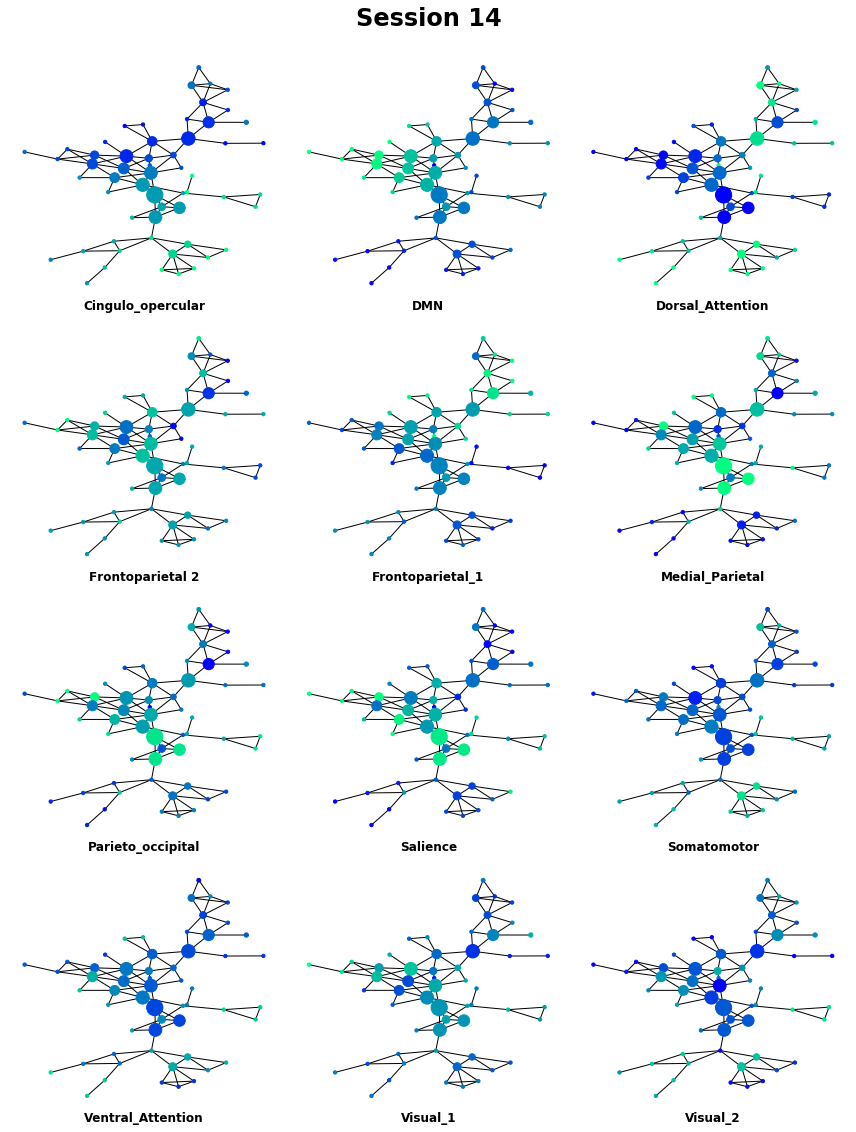

[15]


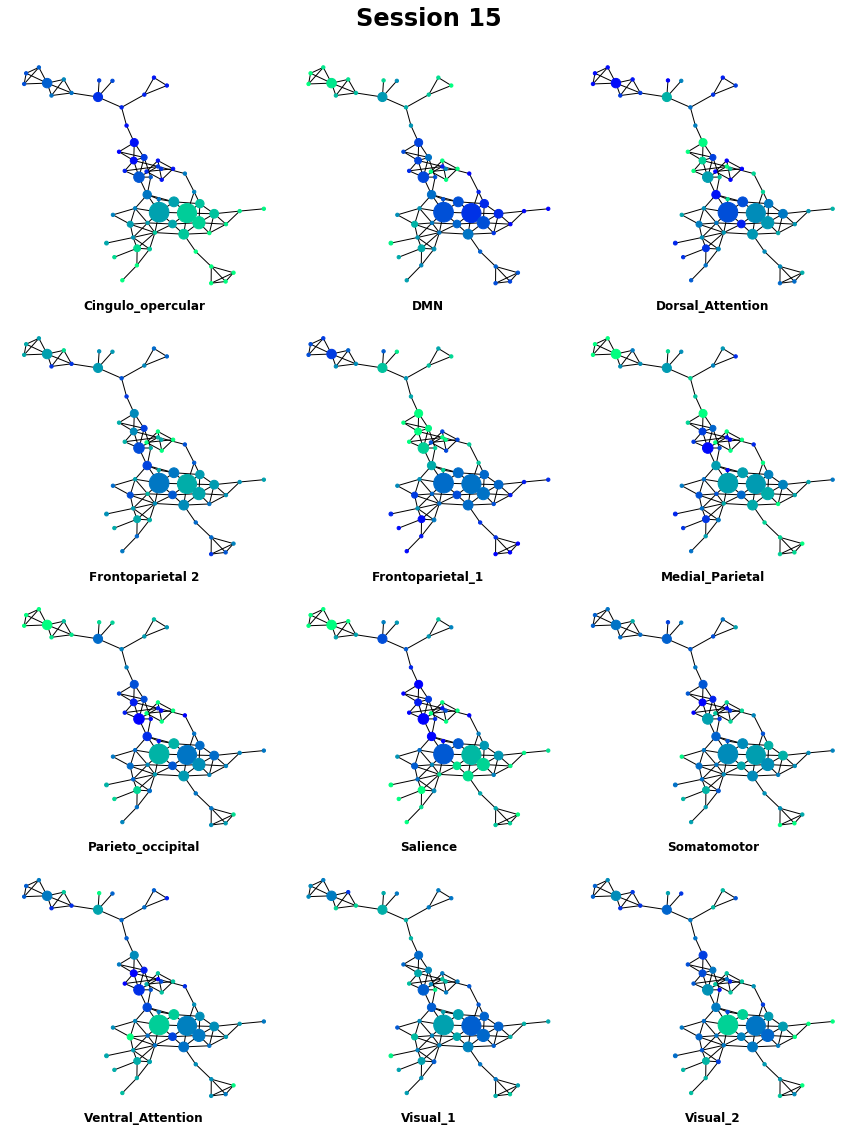

[16]


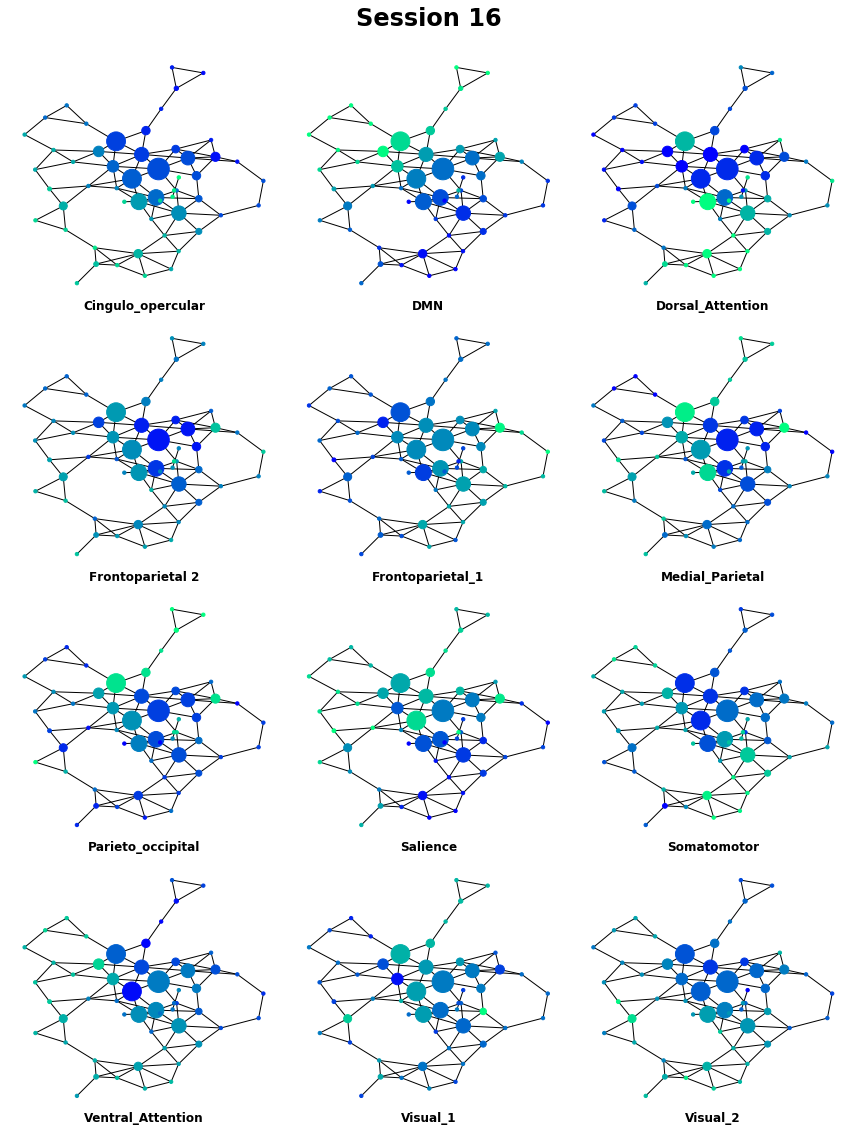

[17]


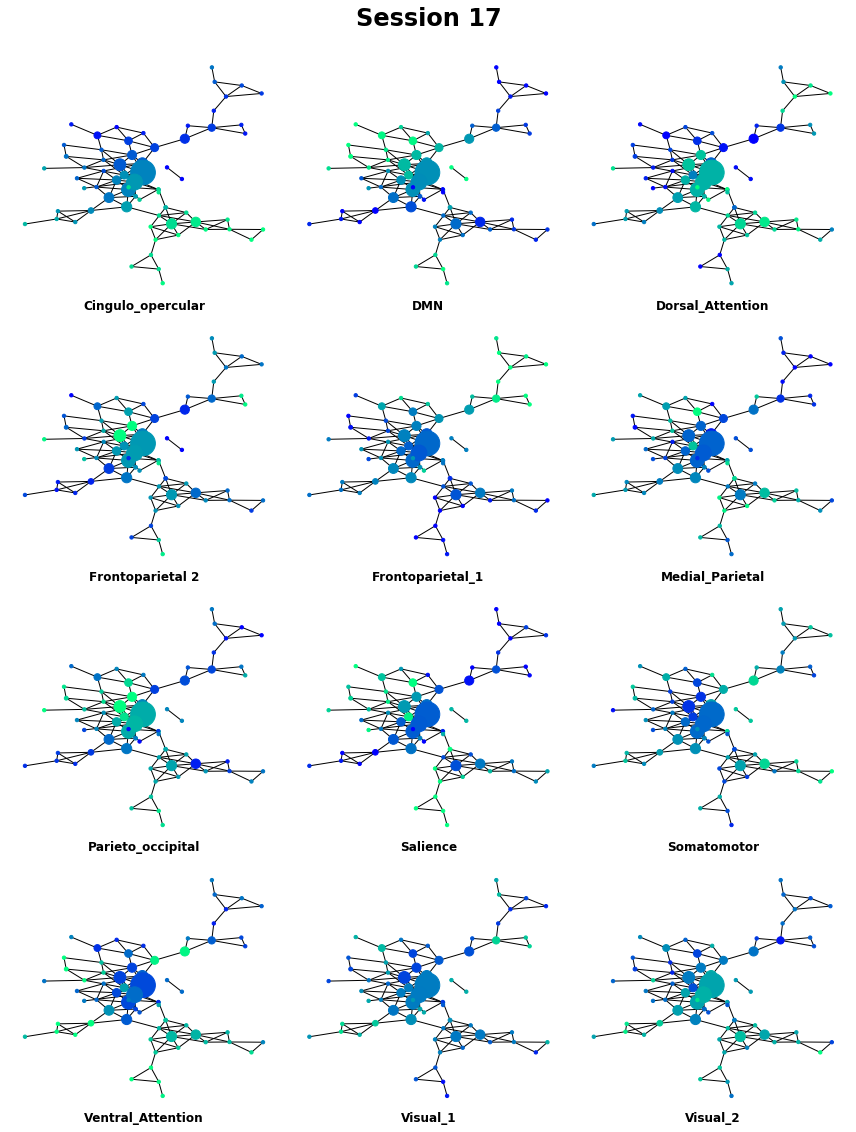

[18]


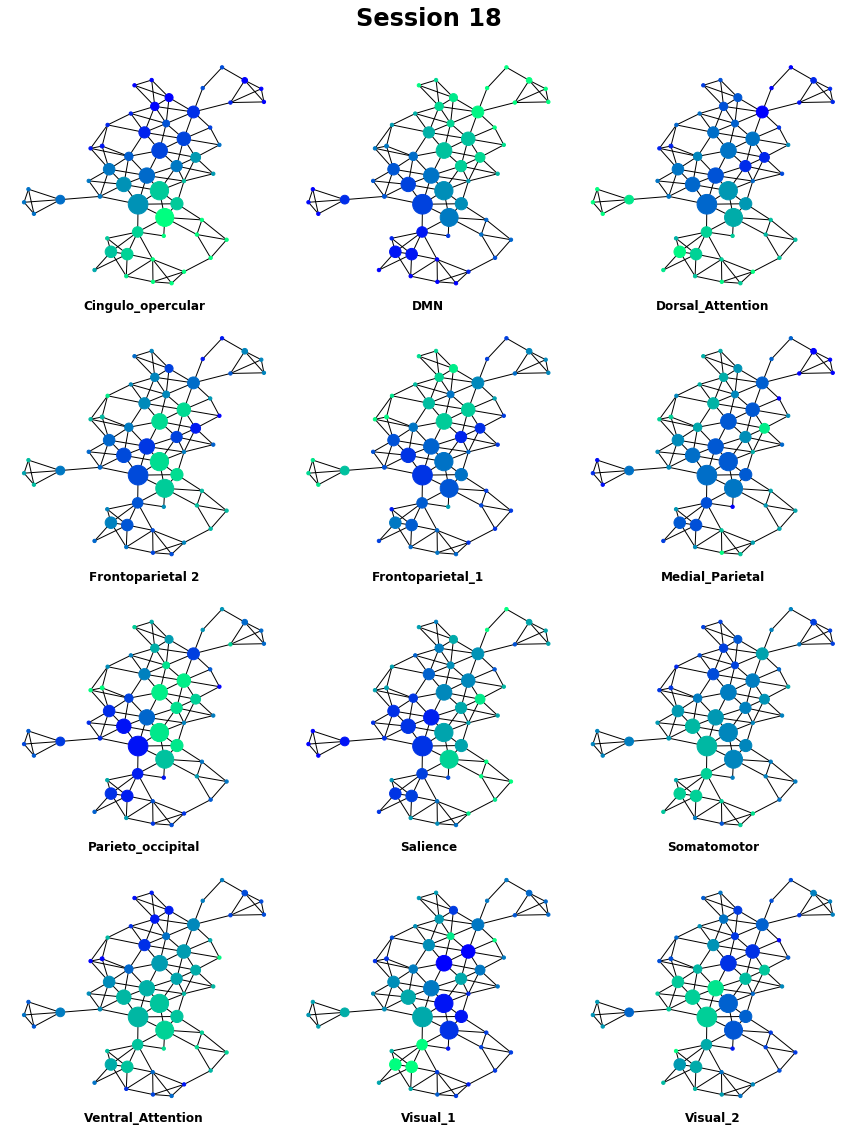

[19]


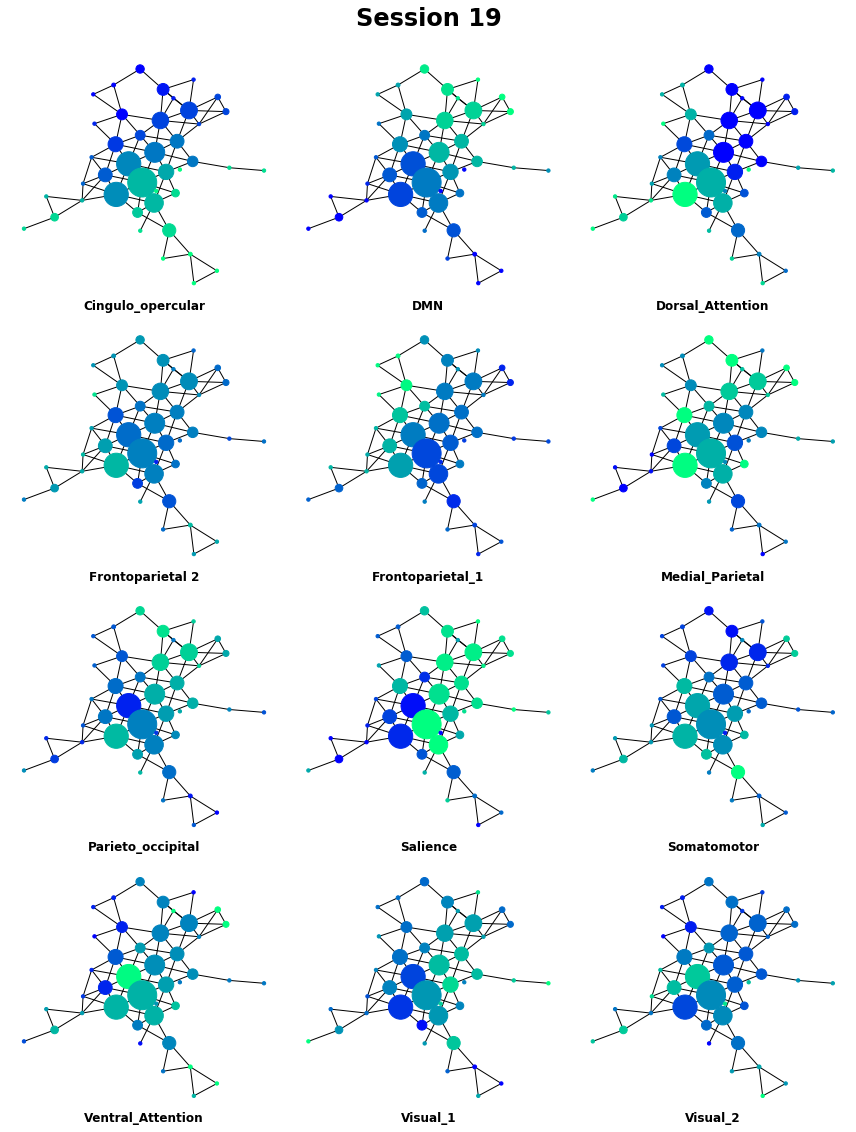

[20]


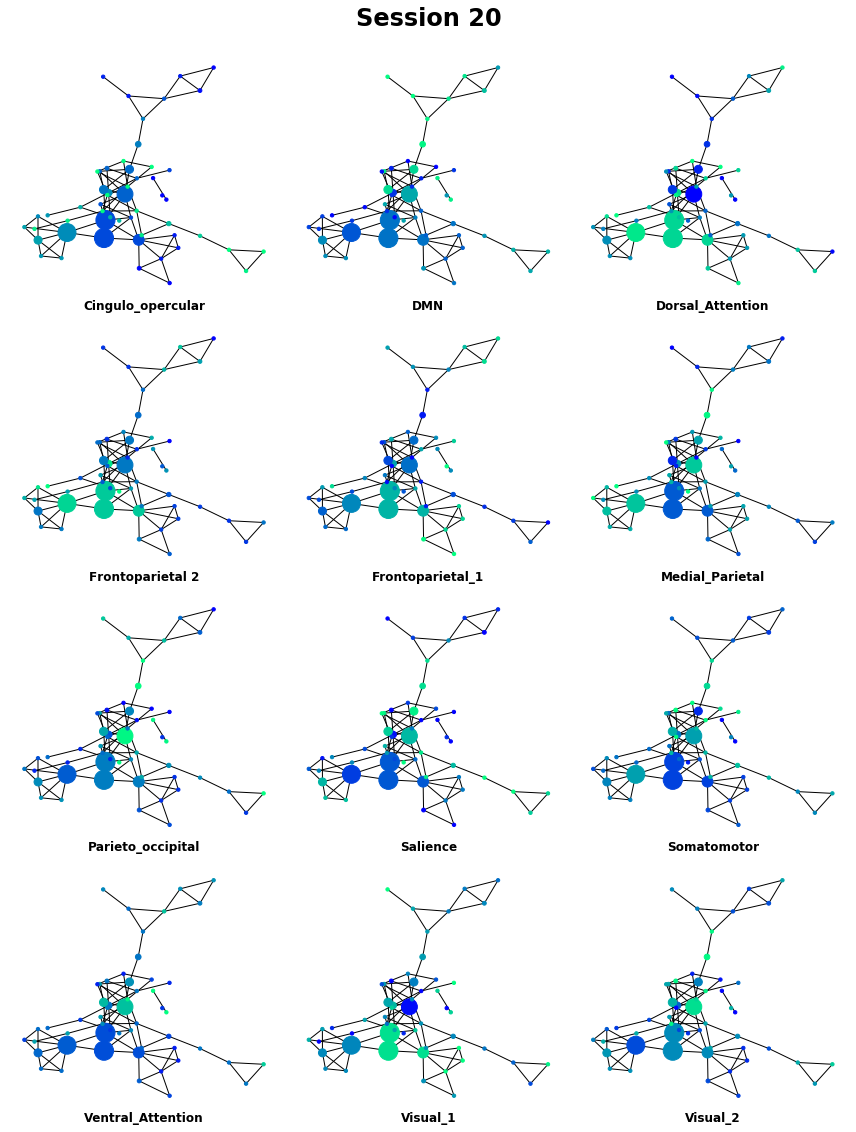

[21]


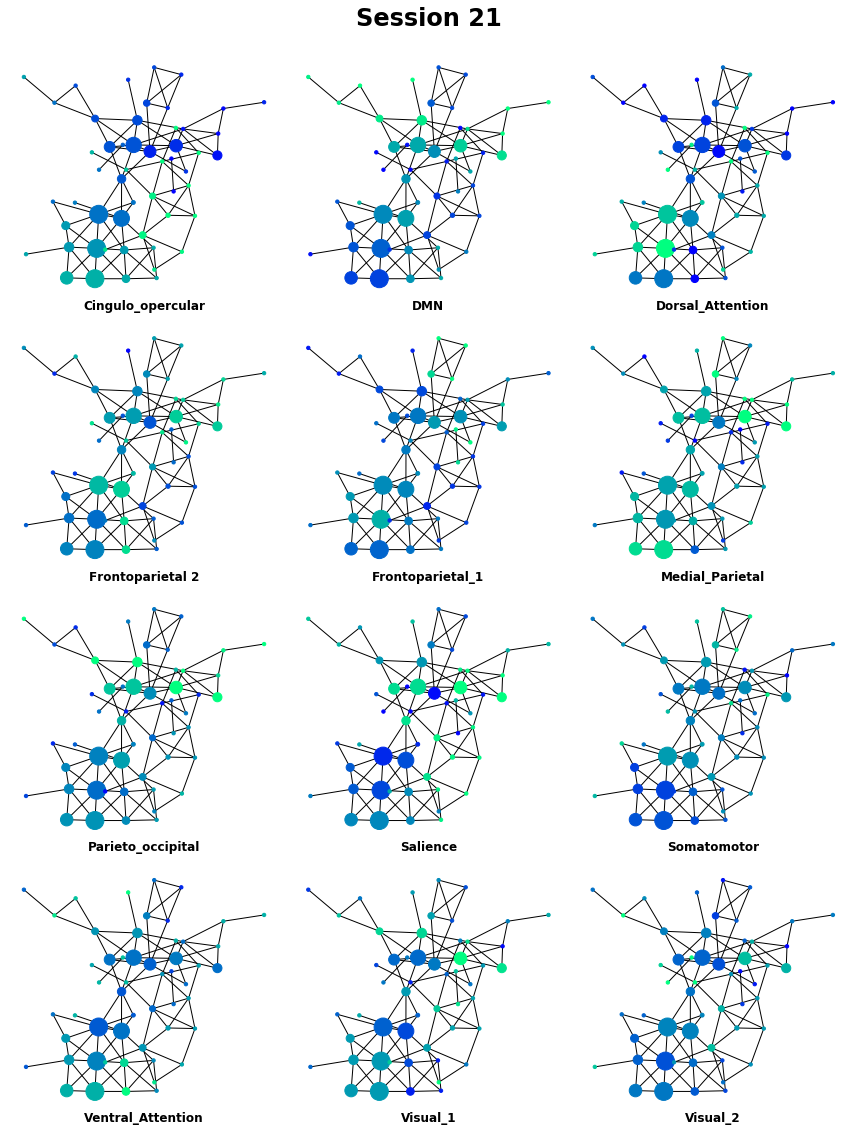

[22]


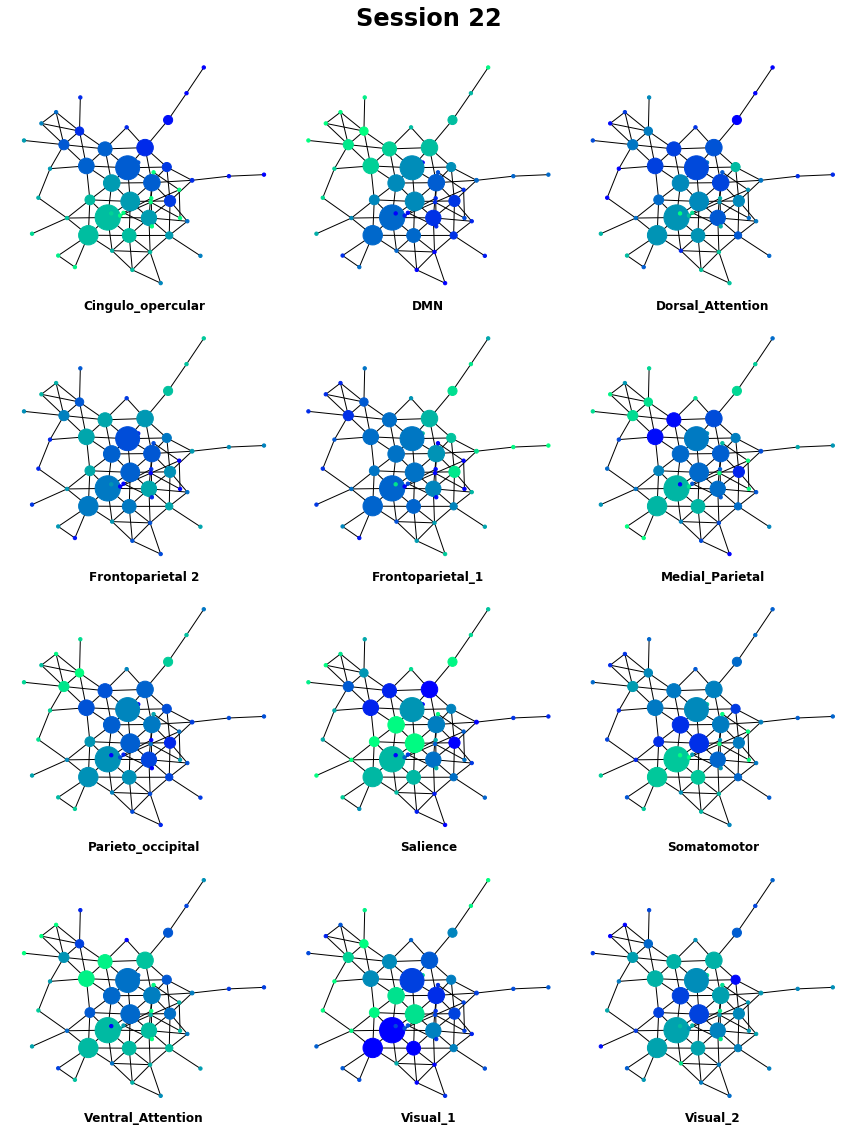

[23]


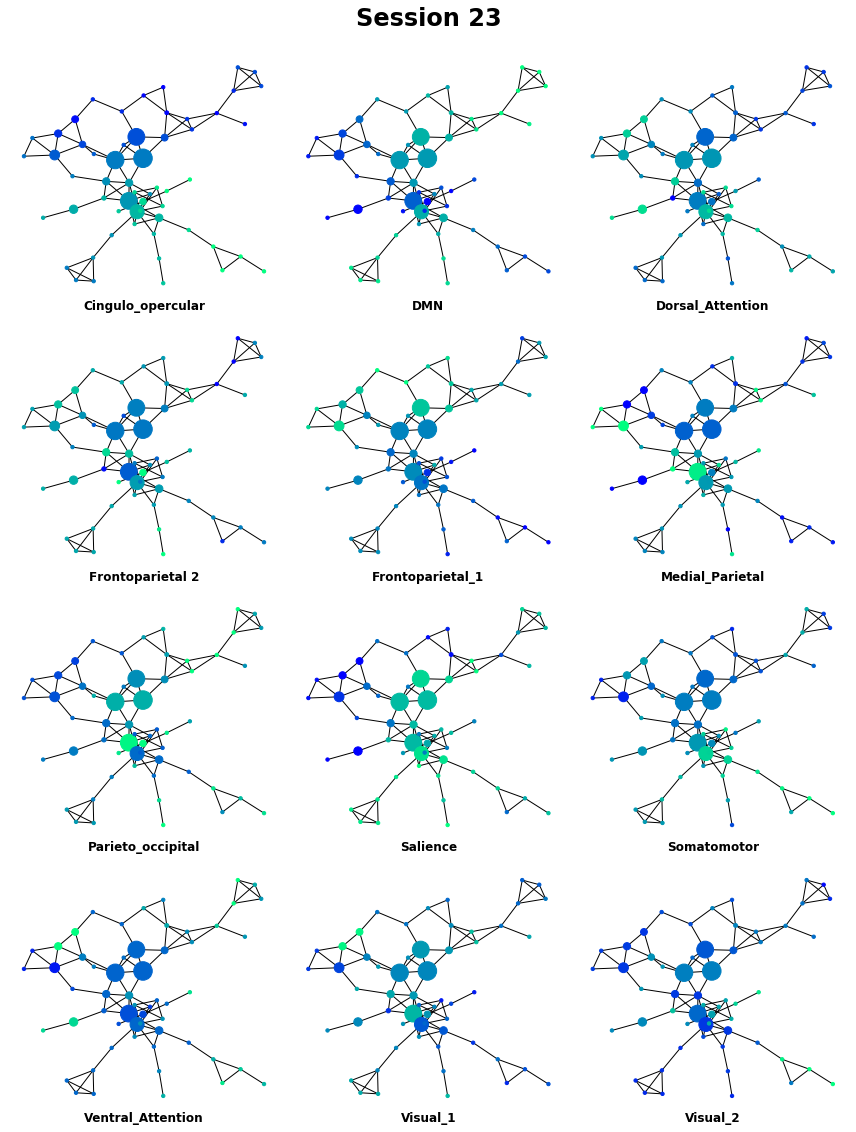

In [267]:
# loop over sessions
for i, session in enumerate(sessions):
    print(session.meta.session_id.unique())

    G = session.mapped.dG.G_.copy()
    color_functions = session.color_functions_rsn.copy()
    color_labels = list(color_functions.columns)

    # color each session by all color functions
    fig, axes = plt.subplots(4, 3, figsize=(12, 16))
    axes = np.ravel(axes)
    for c_i, ax in enumerate(axes):
        draw_G(G.copy(), 
               y=color_functions.iloc[:, c_i], 
               vmin=-1,#combined.color_norms.iloc[c_i].amin, 
               vmax=1,#combined.color_norms.iloc[c_i].amax,
               cmap='winter', edge_cmap='spring',
               layout=nx.kamada_kawai_layout,
               ax=ax)
        
        # finish
        #if (i+1) == len(sessions):
        ax.set_xlabel(color_labels[c_i],
            fontsize=12, fontweight='bold'
            )
        #if c_i == 0:
        #    ax.set_ylabel(str(session.meta.session_id.values[0]), 
        #        fontsize=16, fontweight='bold'
        #        )
    
    plt.suptitle(
        'Session {}'.format(session.meta.session_id[0]),
        fontsize=24, fontweight='bold'
        )
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()
    


## Color (dyneusr)

### Draw graph for each session, color by RSNs (subplots)

In [209]:
## subplots for each session, color_function
fig, axes = plt.subplots(len(sessions)//9, 9, figsize=(2*9, 2*len(sessions)//9))
axes = np.ravel(axes)

# readable label names
color_labels = ["PC_max('{}') = {}".format(*_) if 'panas:' in str(_[0]) else _[-1]
                 for _ in combined.color_functions.columns]

# set color_function index
c_i = [_[0] for _ in combined.color_functions.columns].index('panas:fatigue')

# loop over sessions
for i, session in enumerate(sessions[:axes.shape[0]]):
    
    print("[(i={}, session={})] Drawing graph...".format(
        i, session.meta.session_id.unique()[0])
        ) 
    G = session.mapped.dG.G_.copy()
    color_functions = session.color_functions.copy()

    # color each session by all color functions
    ax = draw_G(G.copy(), 
       y=color_functions.iloc[:, c_i], 
       vmin=combined.color_norms.iloc[c_i].amin, 
       vmax=combined.color_norms.iloc[c_i].amax,
       cmap='winter', edge_cmap='spring',
       layout=nx.kamada_kawai_layout,
       ax=axes[i])
    
    # finish
    if (i+1) == len(sessions):
        ax.set_xlabel(color_labels[c_i],
            fontsize=12, fontweight='bold'
            )
    if (i)%9 == 0:
        ax.set_ylabel(session.meta.session_id.values[0], 
            fontsize=16, fontweight='bold'
            )
   



<Figure size 1296x72 with 0 Axes>